<a href="https://colab.research.google.com/github/dercodeKoenig/colab-KI/blob/main/gan_TPU_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/

import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import numpy as np
import os
from tensorflow.keras import layers
import time
import cv2
from IPython import display

train_images_cartoon = []
small_images_cartoon = []



if os.path.isfile("npfilet1.npy") and os.path.isfile("npfilet2.npy") and os.path.isfile("npfilet3.npy") and os.path.isfile("npfilet4.npy") and os.path.isfile("npfiles.npy"):
    pass
else:
  %cd /content
  !git clone https://github.com/dercodeKoenig/cartoon-faces.git
  train_images_cartoon = []
  small_images_cartoon = []
  z=0
  total = len(os.listdir("cartoon-faces"))
  max=512*100
  files = os.listdir("cartoon-faces")
  while(True):
    if(z>=max):
      break
    print("\r" + str(z) + " / " + str(51200),end="")
    try:
      img = cv2.imread("cartoon-faces/"+files[z])

      img1 = img.copy()
      img3 = cv2.resize(img1, (32,32))
      img3 = cv2.blur(img3,(7,7))
      small_images_cartoon.append(img3)

      img1 = img.copy()
      img2 = cv2.resize(img1, (128,128))
      train_images_cartoon.append(img2)
    
    except:
      print("error: ")
      try:
        print(" cartoon-faces/"+files[z])
      except:
        pass
      max+=1

    z+=1
  print("")
  %cd /content/drive/MyDrive/
  train_images_cartoon1 = train_images_cartoon[int(len(train_images_cartoon)/4*0):int(len(train_images_cartoon)/4*1)]
  train_images_cartoon2 = train_images_cartoon[int(len(train_images_cartoon)/4*1):int(len(train_images_cartoon)/4*2)]
  train_images_cartoon3 = train_images_cartoon[int(len(train_images_cartoon)/4*2):int(len(train_images_cartoon)/4*3)]
  train_images_cartoon4 = train_images_cartoon[int(len(train_images_cartoon)/4*3):int(len(train_images_cartoon)/4*4)]
  
  print("1")
  train_images_cartoon1 = np.array(train_images_cartoon1,dtype=object)
  train_images_cartoon1 = train_images_cartoon1.reshape(train_images_cartoon1.shape[0], 128, 128, 3).astype('float32')
  train_images_cartoon1 = (train_images_cartoon1 - 127.5) / 127.5  # Normalize the images to [-1, 1]
  np.save("npfilet1", train_images_cartoon1)
  del train_images_cartoon1
  
  print("2")
  train_images_cartoon2 = np.array(train_images_cartoon2,dtype=object)
  train_images_cartoon2 = train_images_cartoon2.reshape(train_images_cartoon2.shape[0], 128, 128, 3).astype('float32')
  train_images_cartoon2 = (train_images_cartoon2 - 127.5) / 127.5  # Normalize the images to [-1, 1]
  np.save("npfilet2", train_images_cartoon2)
  del train_images_cartoon2

  print("3")
  train_images_cartoon3 = np.array(train_images_cartoon3,dtype=object)
  train_images_cartoon3 = train_images_cartoon3.reshape(train_images_cartoon3.shape[0], 128, 128, 3).astype('float32')
  train_images_cartoon3 = (train_images_cartoon3 - 127.5) / 127.5  # Normalize the images to [-1, 1]
  np.save("npfilet3", train_images_cartoon3)
  del train_images_cartoon3
  
  print("4") 
  train_images_cartoon4 = np.array(train_images_cartoon4,dtype=object)
  train_images_cartoon4 = train_images_cartoon4.reshape(train_images_cartoon4.shape[0], 128, 128, 3).astype('float32')
  train_images_cartoon4 = (train_images_cartoon4 - 127.5) / 127.5  # Normalize the images to [-1, 1]
  np.save("npfilet4", train_images_cartoon4)
  del train_images_cartoon4
  
  small_images_cartoon = np.array(small_images_cartoon,dtype=object)
  small_images_cartoon = small_images_cartoon.reshape(small_images_cartoon.shape[0], 32, 32, 3).astype('float32')
  small_images_cartoon = (small_images_cartoon - 127.5) / 127.5  # Normalize the images to [-1, 1]
  np.save("npfiles", small_images_cartoon)

  print("ok")

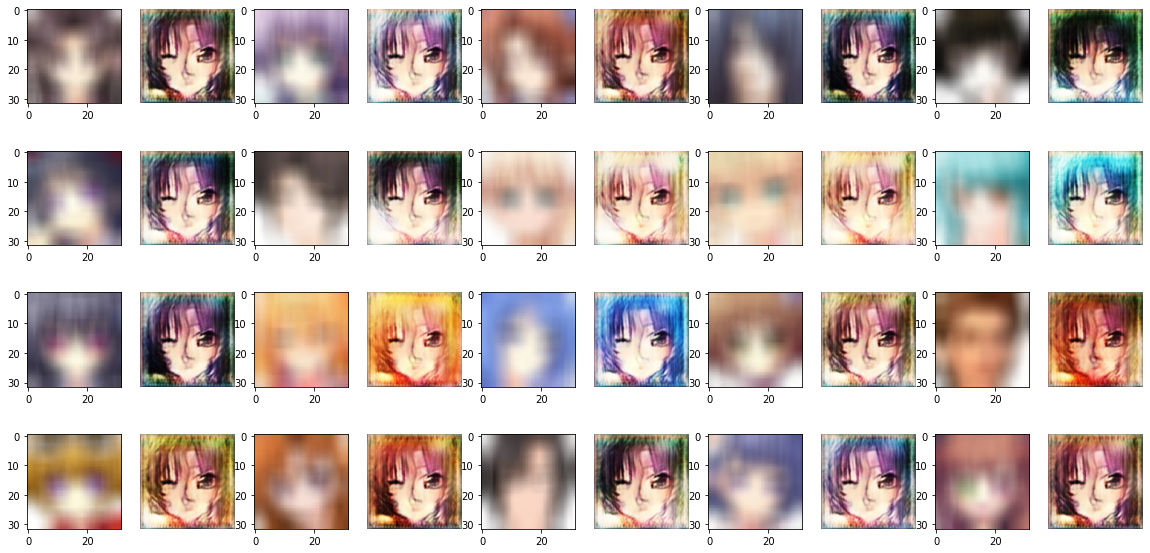

37.860805465
8306

In [ ]:
%cd /content/drive/MyDrive/
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import numpy as np
import os
from tensorflow.keras import layers
import time
import cv2
from IPython import display


small_images_cartoon = np.load("npfiles.npy")
test_img = small_images_cartoon[0:20]
print(small_images_cartoon.shape)

print("All devices: ", tf.config.list_logical_devices('TPU'))
BATCH_SIZE_PER_REPLICA = 4
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * 8 #8TPUs

try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
except:
  strategy = tf.distribute.MirroredStrategy()

small_images_cartoon = tf.data.Dataset.from_tensor_slices((small_images_cartoon)).batch(GLOBAL_BATCH_SIZE)  
small_images_cartoon = strategy.experimental_distribute_dataset(small_images_cartoon)


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(32,32,3)))
    
    model.add(layers.Conv2D(128, 5))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(64, 5))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(32, 5))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(8*8*16, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Reshape((8,8,16)))
    print(model.output_shape)


    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)


    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)


    model.add(layers.Conv2DTranspose(128, (5, 5),padding="same", strides=(2, 2), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
  
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
  
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2DTranspose(128, (5, 5),padding="same", strides=(2, 2), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
  
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
  
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2DTranspose(128, (5, 5),padding="same", strides=(2, 2), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
  
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
  
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Conv2DTranspose(128, (5, 5),padding="same", strides=(2, 2), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
  
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
  
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(3,5,padding="same", activation='tanh', use_bias=False))


    return model


def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input(shape=(128,128,3)))
    
    print(model.output_shape)

    model.add(layers.Conv2D(32, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(32, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Flatten())


    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Dense(1,activation="sigmoid"))

    return model


with strategy.scope():
  discriminator = make_discriminator_model()
  generator = make_generator_model()

  discriminator.summary()
  generator.summary()


with strategy.scope():
# This method returns a helper function to compute cross entropy loss
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False,reduction=tf.keras.losses.Reduction.NONE)

  def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    #print("disc_loss:",total_loss)
    return  tf.nn.compute_average_loss(total_loss, global_batch_size=GLOBAL_BATCH_SIZE)


  def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)


  def apply_blur(img):
    blur = _gaussian_kernel(19, 30, 3, img.dtype)
    img = tf.nn.depthwise_conv2d(img, blur, [1,1,1,1], 'SAME')
    return img


  def generator_loss(fake_output,norm,genr):
    genr=tf.image.resize(genr,[32,32])
    norm=apply_blur(norm)
    genr=apply_blur(genr)
    total_loss=tf.nn.compute_average_loss(((norm-genr)*(norm-genr)))*0.3+tf.nn.compute_average_loss((cross_entropy(tf.ones_like(fake_output), fake_output)))*0.7
   # print("gen_loss:",total_loss)
    return  (total_loss)

  generator_optimizer = tf.keras.optimizers.Adam(0.000005)
  discriminator_optimizer = tf.keras.optimizers.Adam(0.00002)

  @tf.function
  def train_step_cartoon(cartoons,dataset_seed):
      #print("train_step")
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_cartoon_tape :
        #print("generator...")
        generated_images = generator(dataset_seed, training=True)
        #print("disc_real...")
        real_output_cartoon = discriminator(cartoons, training=True)
        #print("disc_fake...")
        fake_output_cartoon = discriminator(generated_images, training=True)
        #print("gen_loss...")
        gen_loss = generator_loss(fake_output_cartoon,dataset_seed,generated_images)
        #print("disc_loss...")
        disc_cartoon_loss = discriminator_loss(real_output_cartoon, fake_output_cartoon)
      #print("gen_grad...")
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      #print("disc_grad...")
      gradients_of_discriminator = disc_cartoon_tape.gradient(disc_cartoon_loss, discriminator.trainable_variables)
      
      #print("opt...")
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      
        
  

def train(dataset_seed,dataset_cartoon, epochs):
  for epoch in range(epochs):
    start = time.time()
    ii=0
    for image_batch in dataset_cartoon:
      for seed_batch in dataset_seed:
        ii+=1
        print("\r" + str(ii),end="")
        strategy.run(train_step_cartoon,args=(image_batch,seed_batch,))

        if(ii%1000==0):
          print("start test")
          generate_images(generator,test_img)
        if(ii%10000==0):
          print("save chkp")
          generator.save_weights('gen_weights.h5', overwrite=True)
          discriminator.save_weights('disc_weights.h5', overwrite=True)
          generate_images(generator,test_img)
  
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


starttime = time.process_time()


def generate_images(model, test_input):    
  predictions = model(test_input,training=False)
  predictions = np.array(predictions)
    
#  test_input = apply_blur(test_input)
  test_input = np.array(test_input,dtype= 'float32')
  test_input = (test_input+1)*127.5

#  predictions=apply_blur(predictions)

  generated_images = np.array(predictions,dtype= 'float32')
#  print(generated_images)
  generated_images = (generated_images+1)*127.5
  cz=0
  cz2 =0
  heighest = 0
  while(True):
      heighest +=1
      if(os.path.exists("outputs/0/"+str(heighest)+".jpg")==False):
        break

  fig = plt.figure(figsize=(20,10))
  for i in generated_images:
    plt.subplot(4, 10, cz2+1)
    plt.imshow(np.array(cv2.cvtColor(test_input[cz], cv2.COLOR_BGR2RGB),dtype= 'int32'))
    plt.subplot(4, 10, cz2+2)
    plt.imshow(np.array(cv2.cvtColor(i, cv2.COLOR_BGR2RGB),dtype= 'int32'))
    plt.axis('off')
    cz+=1
    cz2+=2
  
  display.clear_output(wait=True)
  plt.show()
  global starttime
  end = time.process_time()
  print(end - starttime)
  starttime = time.process_time()


try:
  generator.load_weights('gen_weights.h5')
  discriminator.load_weights('disc_weights.h5')
except:
  print("no weights")

files=["npfilet2.npy","npfilet3.npy","npfilet4.npy","npfilet1.npy"]
for file in files:
  train_images_cartoon = np.load(file)
  train_images_cartoon1=train_images_cartoon[0:int(train_images_cartoon.shape[0]/2)]
  train_images_cartoon2=train_images_cartoon[int(train_images_cartoon.shape[0]/2):int(train_images_cartoon1.shape[0])]

  train_images_cartoon1 = tf.data.Dataset.from_tensor_slices((train_images_cartoon1)).batch(GLOBAL_BATCH_SIZE)  
  train_images_cartoon1 = strategy.experimental_distribute_dataset(train_images_cartoon1)

  train_images_cartoon2 = tf.data.Dataset.from_tensor_slices((train_images_cartoon2)).batch(GLOBAL_BATCH_SIZE)  
  train_images_cartoon2 = strategy.experimental_distribute_dataset(train_images_cartoon2)

  train(small_images_cartoon,train_images_cartoon1, 1)
  print("save chkp")
  generator.save_weights('gen_weights.h5', overwrite=True)
  discriminator.save_weights('disc_weights.h5', overwrite=True)
  train(small_images_cartoon,train_images_cartoon2, 1)
  print("save chkp")
  generator.save_weights('gen_weights.h5', overwrite=True)
  discriminator.save_weights('disc_weights.h5', overwrite=True)
  del train_images_cartoon1


In [2]:
print("save chkp")
generator.save_weights('gen_weights.h5', overwrite=True)
discriminator.save_weights('disc_weights.h5', overwrite=True)

save chkp
